# Daily cycle

Data access example to plot the daily precipitation cycle

In [1]:
import xarray as xr

Open the virtual data set for hourly (1hr) data interpolated to the regular lon-lat grid (CSAM-4i):

In [2]:
url = 'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/1hr/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_1hr_pr_v20220727'
ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
ds

<xarray.Dataset>
Dimensions:    (lon: 676, lat: 451, time: 26304, bnds: 2)
Coordinates:
  * lon        (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat        (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
  * time       (time) datetime64[ns] 2018-06-01T00:30:00 ... 2021-05-31T23:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(100, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                    CF-1.8
    history:                        Thu Jul 14 15:56:12 2022: cdo remap,desti...
    institution:                    Instituto de Fisica de Cantabria, CSIC-Un...
    creation_date:                  2022-07-12-T17:41:54Z
    experiment:                     Evaluation run with ECMWF ERA5 reanalysis...
    experiment_id:                  FPS-SESA
    ...                             ...
    comment:                        Simulation performed at CESGA (https://ww...
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    CORDEX_domain:                  CSAM-4i
    contact:                        meteo@unican.es
    size:                           2147483647
    size_human:                     5.9 GiB

This loaded the full dataset (3 years and all variables) information into `ds`. Variables can be accessed as attributes of this object:

In [3]:
ds.pr

,Array,Chunk
Bytes,29.87 GiB,3.81 MiB
Shape,"(26304, 451, 676)","(100, 100, 100)"
Count,9241 Tasks,9240 Chunks
Type,float32,numpy.ndarray


This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

CPU times: user 3.57 s, sys: 1.03 s, total: 4.61 s
Wall time: 1min 26s


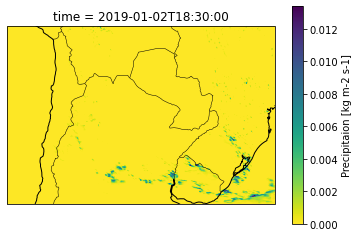

In [4]:
%%time

import cartopy.crs as ccrs
import cartopy.feature as cfea
from matplotlib import cm

p = ds.pr.sel({'time': '2019-01-02 18:30'}).plot(
    transform = ccrs.PlateCarree(),
    #subplot_kws = dict(projection=ccrs.Orthographic(-60, -20)),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.viridis_r
)
p.axes.add_feature(cfea.COASTLINE, linewidth=1)
p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## Extract a single time series

Near Buenos Aires

In [5]:
target_location = dict(lon=-58.48, lat=-34.63)
tseries = ds.pr.sel(target_location, method = 'nearest') * 3600 # hourly flux to mm/h
tseries

<xarray.DataArray 'pr' (time: 26304)>
dask.array<mul, shape=(26304,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 -58.48
    lat      float64 -34.64
  * time     (time) datetime64[ns] 2018-06-01T00:30:00 ... 2021-05-31T23:30:00

## Compute and plot the daily cycle

In [6]:
dly_cycle = tseries.sel(time=tseries.time.dt.season == 'DJF').groupby('time.hour').mean(dim='time')

All of the above were lazy operations. Now it will need to actually retrieve data and compute the daily cycle:

In [ ]:
%%time

dly_cycle.plot()